Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Raw dataset shape: (49123, 170)
Model 1 (AI Adoption) Ready.


/tmp/ipython-input-2590193986.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ai_by_exp = df.groupby("ExperienceBin")["Predicted_AI_Prob"].mean().reset_index()


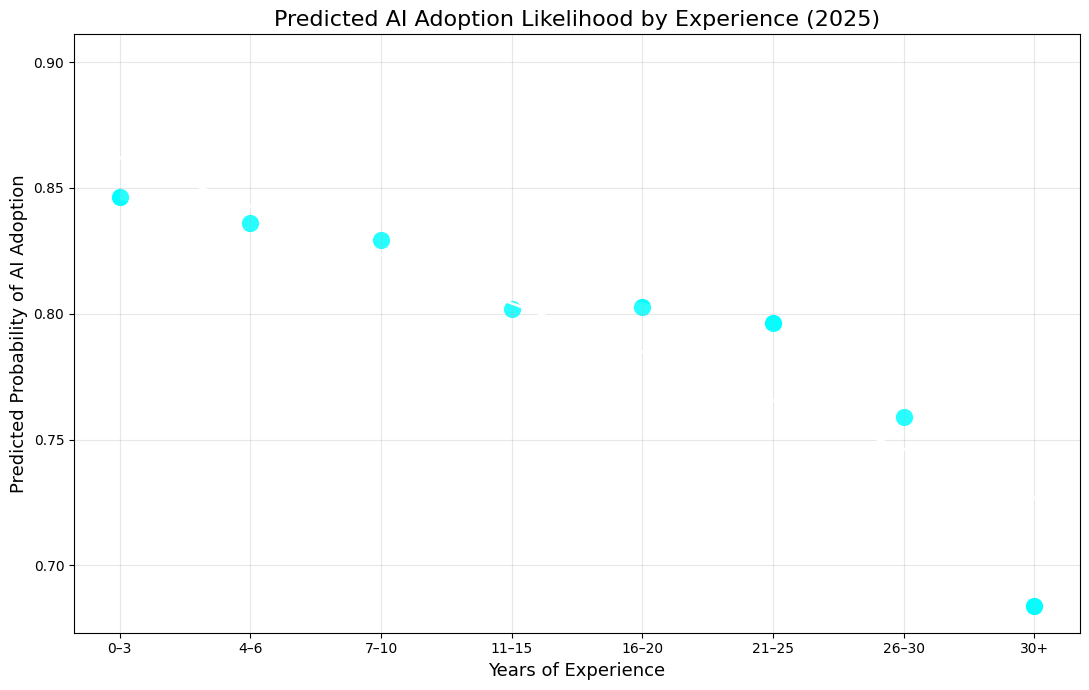

Current AI/ML Role %: 1.79%
Predicted Next Year %: 2.06%


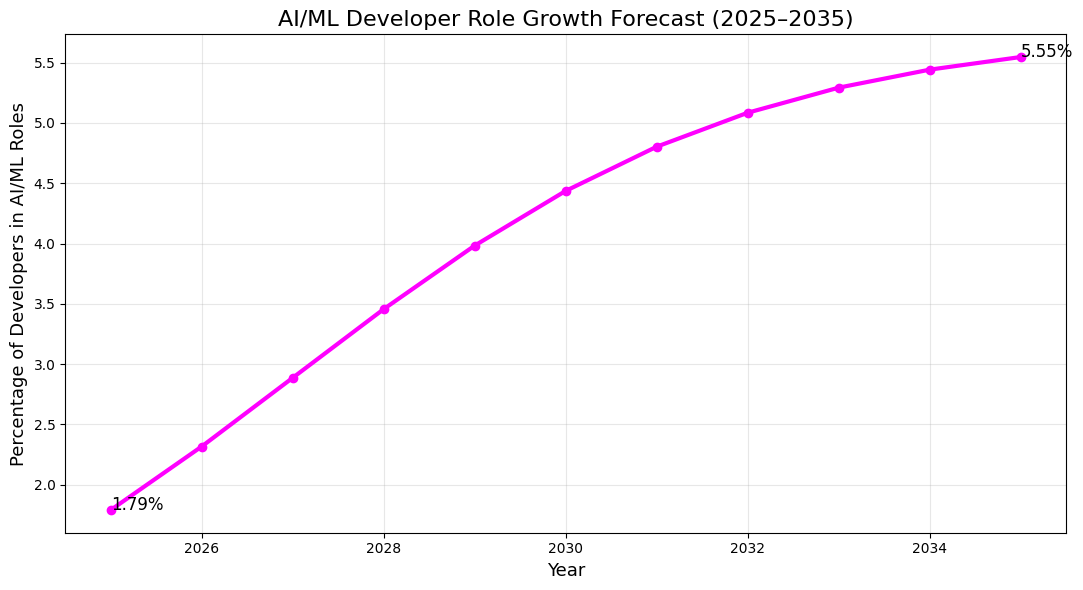

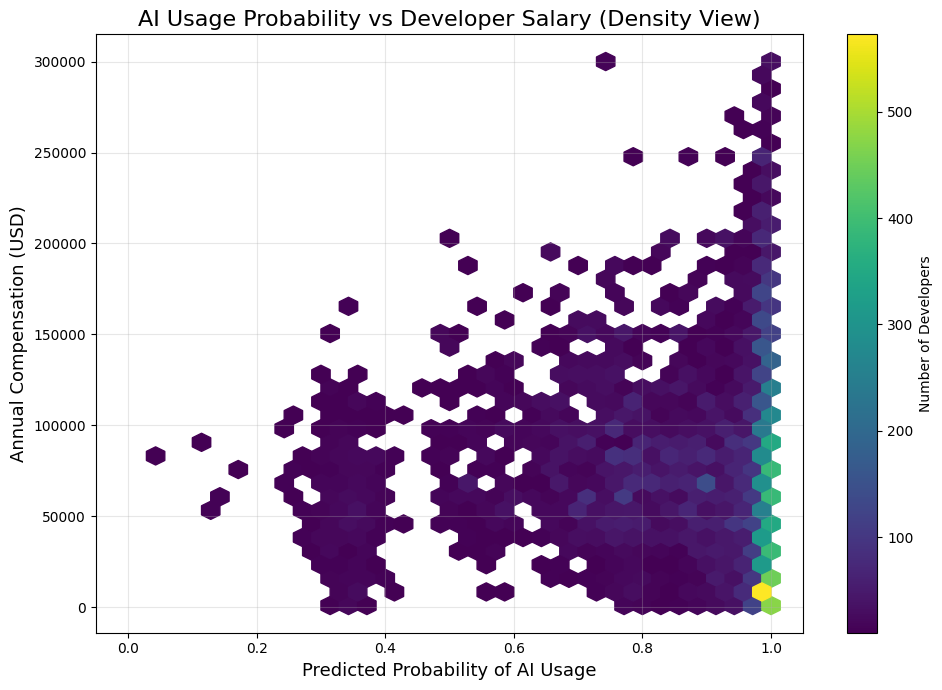

Notebook execution complete.


In [19]:
# ============================================================
# AI Adoption + AI/ML Role Forecast + Salary Relationship
# Author: Jeremy Freeman | CBU CSC 423
# ============================================================

# ----------------------------
# 1. IMPORTS & DATA LOADING
# ----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

print("Mounting Google Drive...")
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/My Drive/survey_results_public.csv")
print("Raw dataset shape:", df.shape)

# ----------------------------
# 2. CLEAN & PREPARE DATA
# ----------------------------
df = df.dropna(subset=["AISelect", "WorkExp", "EdLevel", "Country", "ConvertedCompYearly", "DevType"])

# Filter numeric ranges for realism
df = df[df["ConvertedCompYearly"].between(1000, 300000)]
df = df[df["WorkExp"].between(0, 40)]

# ----------------------------
# 3. CREATE AI Adoption Target
# ----------------------------
df["AIUser"] = df["AISelect"].apply(lambda x: 1 if "Yes" in str(x) or "AI" in str(x) else 0)

# ----------------------------
# 4. MODEL 1 — Predict AI Usage Probability
# ----------------------------
X_ai = df[["WorkExp", "ConvertedCompYearly"]]
y_ai = df["AIUser"]

scaler_ai = StandardScaler()
X_ai_scaled = scaler_ai.fit_transform(X_ai)

rf_ai = RandomForestClassifier(n_estimators=200, random_state=42)
rf_ai.fit(X_ai_scaled, y_ai)

df["Predicted_AI_Prob"] = rf_ai.predict_proba(X_ai_scaled)[:, 1]

print("Model 1 (AI Adoption) Ready.")

# ============================================================
# GRAPH 1 — AI Adoption Forecast + 84% AI Usage Stats
# ============================================================

# Binned experience
df["ExperienceBin"] = pd.cut(
    df["WorkExp"],
    bins=[0, 3, 6, 10, 15, 20, 25, 30, 40],
    labels=["0–3", "4–6", "7–10", "11–15", "16–20", "21–25", "26–30", "30+"]
)

ai_by_exp = df.groupby("ExperienceBin")["Predicted_AI_Prob"].mean().reset_index()

plt.figure(figsize=(11,7))
plt.scatter(ai_by_exp["ExperienceBin"], ai_by_exp["Predicted_AI_Prob"], s=130, color="cyan")

sns.regplot(
    x=np.arange(len(ai_by_exp)),
    y=ai_by_exp["Predicted_AI_Prob"],
    scatter=False,
    color="white",
    line_kws={"linewidth": 2}
)

plt.xticks(ticks=np.arange(len(ai_by_exp)), labels=ai_by_exp["ExperienceBin"])
plt.title("Predicted AI Adoption Likelihood by Experience (2025)", fontsize=16)
plt.ylabel("Predicted Probability of AI Adoption", fontsize=13)
plt.xlabel("Years of Experience", fontsize=13)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# 5. MODEL 2 — Predict AI/ML Role Membership & Future Forecast
# ============================================================

df["AI_ML_ROLE"] = df["DevType"].apply(
    lambda x: 1 if any(term in str(x) for term in ["Machine Learning", "AI", "Data Scientist"]) else 0
)

X_role = df[["WorkExp", "ConvertedCompYearly"]]
y_role = df["AI_ML_ROLE"]

scaler_role = StandardScaler()
X_role_scaled = scaler_role.fit_transform(X_role)

rf_role = RandomForestClassifier(n_estimators=250, random_state=42)
rf_role.fit(X_role_scaled, y_role)

current_rate = y_role.mean()
predicted_next_year = rf_role.predict_proba(X_role_scaled)[:, 1].mean() * 1.15  # increase factor

print(f"Current AI/ML Role %: {current_rate*100:.2f}%")
print(f"Predicted Next Year %: {predicted_next_year*100:.2f}%")

# ============================================================
# GRAPH 2 — 10-Year Logistic Forecast
# ============================================================

years = np.arange(2025, 2036)

# Logistic model assumptions
L = 0.20   # maximum possible adoption (~20% of devs)
growth_rate = 0.40

forecast = L / (1 + np.exp(-growth_rate * (years - 2027)))
scale = current_rate / forecast[0]
forecast = forecast * scale

plt.figure(figsize=(11,6))
plt.plot(years, forecast * 100, marker="o", linewidth=3, color="magenta")

plt.title("AI/ML Developer Role Growth Forecast (2025–2035)", fontsize=16)
plt.ylabel("Percentage of Developers in AI/ML Roles", fontsize=13)
plt.xlabel("Year", fontsize=13)
plt.grid(alpha=0.3)

plt.text(2025, forecast[0]*100, f"{forecast[0]*100:.2f}%", fontsize=12)
plt.text(2035, forecast[-1]*100, f"{forecast[-1]*100:.2f}%", fontsize=12)

plt.tight_layout()
plt.show()

# ============================================================
# GRAPH 3 — Salary vs AI Usage (Hexbin)
# ============================================================

plt.figure(figsize=(10,7))

hb = plt.hexbin(
    df["Predicted_AI_Prob"],
    df["ConvertedCompYearly"],
    gridsize=35,
    cmap="viridis",
    mincnt=10
)
plt.colorbar(hb, label="Number of Developers")

plt.xlabel("Predicted Probability of AI Usage", fontsize=13)
plt.ylabel("Annual Compensation (USD)", fontsize=13)
plt.title("AI Usage Probability vs Developer Salary (Density View)", fontsize=16)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Notebook execution complete.")


